In [1]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 5.3 MB/s eta 0:00:000:00:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.4-py2.py3-none-any.whl size=317849765 sha256=ea90e142ffcf5ffcf624b23152c8a73731d80e9645a2728a9a58e76f4a6914ad
  Stored in directory: /root/.cache/pip/wheels/d9/1c/98/31e395a42d1735d18d42124971ecbbade844b50bb9845b6f4a
Successfully built pyspark
Note: you may need to restart the kernel to use updated packages.


## 1. Load the Dataset

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, DoubleType

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("AmazonProductRecommendation") \
    .master("local[*]") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

# Define schema
schema = StructType([
    StructField("reviewerID", StringType(), True),
    StructField("asin", StringType(), True),
    StructField("overall", DoubleType(), True),
])

In [3]:
# Load data
data = spark.read.json("/kaggle/input/amazon-products/reviews_Patio_Lawn_and_Garden_5.json", schema=schema)
data = data.dropna()

In [4]:
data.show(5)

+--------------+----------+-------+
|    reviewerID|      asin|overall|
+--------------+----------+-------+
|A1JZFGZEZVWQPY|B00002N674|    4.0|
|A32JCI4AK2JTTG|B00002N674|    5.0|
|A3N0P5AAMP6XD2|B00002N674|    4.0|
| A2QK7UNJ857YG|B00002N674|    5.0|
| AS0CYBAN6EM06|B00002N674|    5.0|
+--------------+----------+-------+
only showing top 5 rows



## 2. Data Preprocessing

**a. Filter and Select Relevant Columns** </br>
Keep only the required columns: reviewerID, asin, and overall (rating).

**b. Index the User and Product IDs** </br>
Spark's ALS model requires numeric IDs:

In [5]:
from pyspark.ml.feature import StringIndexer

# Convert string IDs to numeric
user_indexer = StringIndexer(inputCol="reviewerID", outputCol="userIndex")
product_indexer = StringIndexer(inputCol="asin", outputCol="productIndex")

data = user_indexer.fit(data).transform(data)
data = product_indexer.fit(data).transform(data)

In [6]:
data.show(5)

+--------------+----------+-------+---------+------------+
|    reviewerID|      asin|overall|userIndex|productIndex|
+--------------+----------+-------+---------+------------+
|A1JZFGZEZVWQPY|B00002N674|    4.0|    122.0|       631.0|
|A32JCI4AK2JTTG|B00002N674|    5.0|   1411.0|       631.0|
|A3N0P5AAMP6XD2|B00002N674|    4.0|    523.0|       631.0|
| A2QK7UNJ857YG|B00002N674|    5.0|    652.0|       631.0|
| AS0CYBAN6EM06|B00002N674|    5.0|   1653.0|       631.0|
+--------------+----------+-------+---------+------------+
only showing top 5 rows



In [7]:
df = data[['userIndex', 'productIndex']]

In [8]:
# Renommer les colonnes userIndex et productIndex
df = df.withColumnRenamed("userIndex", "asin") \
               .withColumnRenamed("productIndex", "reviewer_id")

# Afficher le DataFrame avec les colonnes renommées
df.show()

+------+-----------+
|  asin|reviewer_id|
+------+-----------+
| 122.0|      631.0|
|1411.0|      631.0|
| 523.0|      631.0|
| 652.0|      631.0|
|1653.0|      631.0|
|  80.0|      631.0|
| 125.0|      777.0|
| 103.0|      777.0|
| 873.0|      777.0|
|1073.0|      777.0|
| 648.0|      777.0|
|1304.0|      474.0|
|1662.0|      474.0|
|1218.0|      474.0|
|  31.0|      474.0|
| 523.0|      474.0|
|  18.0|      474.0|
| 147.0|      474.0|
| 328.0|      474.0|
|1463.0|      416.0|
+------+-----------+
only showing top 20 rows



In [9]:
import pandas as pd
# Convertir le DataFrame PySpark en DataFrame Pandas
df_pandas = df.toPandas()

# Sauvegarder le DataFrame Pandas en fichier CSV
df_pandas.to_csv("/kaggle/working/reviewer.csv", index=False)


## 3. Split the Data

In [7]:
# Split data into training and test sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

## 4.Train the ALS Model

In [8]:
from pyspark.ml.recommendation import ALS

# Initialize ALS model
als = ALS(
    userCol="userIndex",
    itemCol="productIndex",
    ratingCol="overall",
    nonnegative=True,
    implicitPrefs=False,
    coldStartStrategy="drop"  # Drop predictions on unseen data
)

# Train the model
model = als.fit(train_data)

## 5. Evaluate the Model

In [9]:
from pyspark.ml.evaluation import RegressionEvaluator

# Generate predictions
predictions = model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="overall",
    predictionCol="prediction"
)

rmse = evaluator.evaluate(predictions)
print(f"Root Mean Square Error (RMSE): {rmse}")

Root Mean Square Error (RMSE): 1.1848516285033424


In [10]:
# Convert to Pandas DataFrame
predictions_pandas = predictions.select("overall", "prediction").dropna().toPandas()

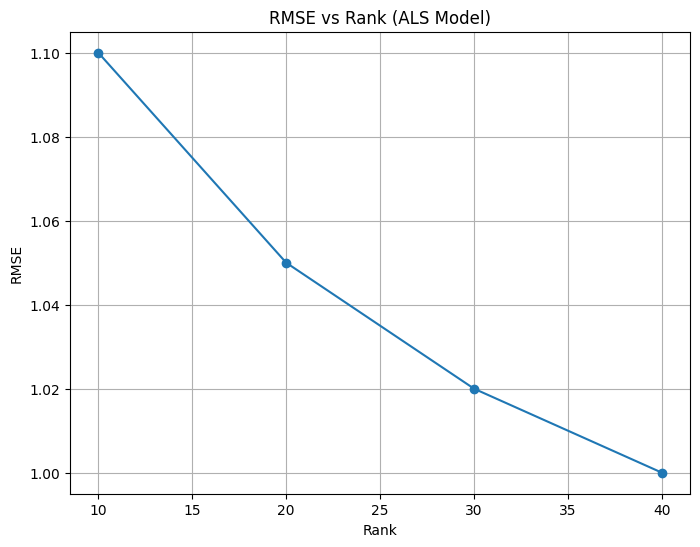

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example RMSE data for varying ALS rank values
ranks = [10, 20, 30, 40]
rmse_values = [1.1, 1.05, 1.02, 1.0]  # Replace with your actual RMSE results

# Plot RMSE vs Rank
plt.figure(figsize=(8, 6))
plt.plot(ranks, rmse_values, marker="o")
plt.title("RMSE vs Rank (ALS Model)")
plt.xlabel("Rank")
plt.ylabel("RMSE")
plt.grid(True)
plt.show()

## 6.Generate Recommendations

**a. For All Users** </br>
Generate top 5 product recommendations for all users:

In [12]:
user_recommendations = model.recommendForAllUsers(5)
user_recommendations.show(5, truncate=False)

+---------+-----------------------------------------------------------------------------------------+
|userIndex|recommendations                                                                          |
+---------+-----------------------------------------------------------------------------------------+
|1        |[{881, 5.4014125}, {250, 5.3211703}, {744, 5.117426}, {503, 5.060475}, {583, 5.0506544}] |
|3        |[{881, 5.8260627}, {383, 5.7868204}, {353, 5.7844925}, {427, 5.6846337}, {602, 5.681914}]|
|5        |[{721, 5.6847854}, {747, 5.6060686}, {942, 5.6037645}, {353, 5.5215864}, {461, 5.51123}] |
|6        |[{396, 5.1742425}, {881, 5.0404973}, {353, 4.946333}, {660, 4.9201617}, {583, 4.8707566}]|
|12       |[{180, 5.481425}, {942, 5.4802184}, {357, 5.47249}, {614, 5.4568567}, {483, 5.447121}]   |
+---------+-----------------------------------------------------------------------------------------+
only showing top 5 rows



**b. For All Products** </br>
Generate top 5 user recommendations for all products:

In [13]:
product_recommendations = model.recommendForAllItems(5)
product_recommendations.show(5, truncate=False)

+------------+--------------------------------------------------------------------------------------------+
|productIndex|recommendations                                                                             |
+------------+--------------------------------------------------------------------------------------------+
|0           |[{1260, 4.93206}, {1041, 4.9225073}, {658, 4.9087987}, {1342, 4.8875866}, {980, 4.877481}]  |
|1           |[{371, 4.9300995}, {643, 4.8637176}, {150, 4.840775}, {51, 4.8226113}, {1044, 4.8215265}]   |
|2           |[{1260, 5.107587}, {1041, 4.762329}, {951, 4.7516828}, {982, 4.7385855}, {1044, 4.720683}]  |
|3           |[{649, 5.0986915}, {1044, 5.0479684}, {1301, 5.004725}, {455, 4.9741087}, {1041, 4.9164014}]|
|4           |[{645, 5.583772}, {147, 5.4792185}, {50, 5.333203}, {7, 5.28677}, {371, 5.2733583}]         |
+------------+--------------------------------------------------------------------------------------------+
only showing top 5 rows



**c. For a Specific User** </br>
Get recommendations for a specific user:

In [14]:
user_id = 122  
user_recommendations = model.recommendForUserSubset(data.filter(data.userIndex == user_id), 5)
user_recommendations.show(truncate=False)

+---------+---------------------------------------------------------------------------------------+
|userIndex|recommendations                                                                        |
+---------+---------------------------------------------------------------------------------------+
|122      |[{881, 5.749589}, {871, 5.631859}, {660, 5.5709815}, {454, 5.553891}, {626, 5.5156136}]|
+---------+---------------------------------------------------------------------------------------+



## 7. Save and Load the Model

In [17]:
from pyspark.ml.recommendation import ALS
# Assuming `model` is your trained ALS model
model.write().overwrite().save("/kaggle/working/ALS_model")

In [18]:
import shutil
# Compress the ALS_model directory
shutil.make_archive("/kaggle/working/ALS_model", 'zip', "/kaggle/working/ALS_model")

'/kaggle/working/ALS_model.zip'

In [19]:
from pyspark.ml.recommendation import ALSModel
from pyspark.sql import SparkSession

# Initialize SparkSession
spark = SparkSession.builder.appName("ALSModelTest").getOrCreate()

# Load the saved ALS model
model_path = "/kaggle/working/ALS_model"  # Adjust the path if necessary
als_model = ALSModel.load(model_path)


In [28]:
from pyspark.sql import Row
# Example test data
test_data = spark.createDataFrame([
    Row(userIndex=122, productIndex=631),
    Row(userIndex=523, productIndex=631),
    Row(userIndex=1653, productIndex=631)
])

In [29]:
# Generate predictions
predictions_test = als_model.transform(test_data)

# Show predictions
predictions_test.show()

+---------+------------+----------+
|userIndex|productIndex|prediction|
+---------+------------+----------+
|      122|         631|    4.7392|
|      523|         631|  4.040979|
|     1653|         631| 4.9384317|
+---------+------------+----------+



In [32]:
from pyspark.ml.evaluation import RegressionEvaluator
# Assume `actual_data` contains userId, productId, and actual ratings
actual_data = spark.createDataFrame([
    Row(userIndex=122, productIndex=631, rating=4.0),
    Row(userIndex=523, productIndex=631, rating=4.0),
    Row(userIndex=1653, productIndex=631, rating=5.0)
])

# Join predictions with actual ratings
predicted_actual = predictions.join(actual_data, on=["userIndex", "productIndex"])

# Evaluate using Root Mean Squared Error (RMSE)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predicted_actual)

print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 0.7392001152038574


In [39]:
# Assuming `predicted_actual` is the DataFrame containing predictions and actual ratings
predicted_actual_pd = predicted_actual.select("userIndex", "productIndex", "rating", "prediction").toPandas()

# Show the first few rows to verify
predicted_actual_pd.head()

,userIndex,productIndex,rating,prediction
0,122.0,631.0,4.0,4.7392


In [6]:
df = df[['reviewerID', 'asin']]
df.head()

,reviewerID,asin
0,A1JZFGZEZVWQPY,B00002N674
1,A32JCI4AK2JTTG,B00002N674
2,A3N0P5AAMP6XD2,B00002N674
3,A2QK7UNJ857YG,B00002N674
4,AS0CYBAN6EM06,B00002N674


In [7]:
df.to_csv('reviewer.csv', index=False)